### **INTRODUCTION**
In the sections below, we cover in depth analysis of some Model- free   RL algorithms such as  Deep Deterministic Policy Gradient Algorithm, Proximal Policy Optimization Algorithm, Soft actor critic algorithms on Mountain-Car Open-AI Gym environment and provide a comparative study of performance with respect to random actions. We have explained terminologies and mechanism of each of the algorithms encompassing intuition, necessity, advantages and probable disadvantages wherever possible.  




### **ENVIRONMENT:** 
**Open AI Gym "MountainCarContinuous-v0"**

An underpowered car must climb a one-dimensional hill to reach a target. Unlike MountainCar v0, the action (engine force applied) is allowed to be a continuous value.

The target is on top of a hill on the right-hand side of the car. If the car reaches it or goes beyond, the episode terminates.

On the left-hand side, there is another hill. Climbing this hill can be used to gain potential energy and accelerate towards the target. On top of this second hill, the car cannot go further than a position equal to -1, as if there was a wall. Hitting this limit does not generate a penalty (it might in a more challenging version).


 **States:**

 Num  |	Observation |	Min    |	Max 
--- | ---| ---| ---
 0   |	CarPosition |	-1.2   |	0.6
  1   |	CarVelocity |-0.07   |	0.07

 **Actions**

  Num|	Action
--- |---
0	| Push car to the left (negative value) or to the right (positive value)

**Rewards**

Reward is 100 for reaching the target of the hill on the right hand side, minus the squared sum of actions from start to goal.

This reward function raises an exploration challenge, because if the agent does not reach the target soon enough, it will figure out that it is better not to move, and won't find the target anymore.

Note that this reward is unusual with respect to most published work, where the goal was to reach the target as fast as possible, hence favouring a bang-bang strategy.


**Starting State** 

Position between -0.6 and -0.4, null velocity.

**Episode Termination**

Position equal to 0.5. A constraint on velocity might be added in a more challenging version.

Adding a maximum number of steps might be a good idea.






### Starting with Random actions


In [0]:
!pip install stable-baselines[mpi]
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.8.0 box2d box2d-kengz
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x

### Imports

In [0]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines.ddpg.policies import  MlpPolicy, CnnPolicy
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines import DDPG, PPO2, PPO1, SAC
from stable_baselines.ddpg import  AdaptiveParamNoiseSpec, NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines import results_plotter

In [0]:
# Create log dir to store information of states, actions, rewards, new states in files 
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)


### Baseline by choosing random actions at all states

Text(0, 0.5, 'Rewards')

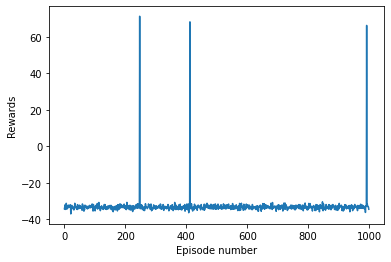

In [0]:
#create the environment
env = gym.make('MountainCarContinuous-v0')
n_games = 1000 #number of Episodes
rewards = np.zeros(n_games)
#Iterating through all episodes
for i in range(n_games):
    obs = env.reset()
    done = False
    episode_reward = 0
    #Stop when done is randomly set to true
    while not done:
      #Take action by sampling from action space randomly
        action = env.action_space.sample()
        # Update new state and keep count of rewards and check status of done
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        #env.render()
    rewards[i] = episode_reward
# Plot progress of agent across all episodes.
plt.plot(rewards)
plt.xlabel('Episode number')
plt.ylabel('Rewards')


We see that agent almost never reches goal state. In instances that it does reach goal state, it never learns anything and it is not doing specifically good after running for any number of episodes
Mountain car gives positive reward only when we reach the goal state so for calculating past 100 rewards we must achieve a score of averaging to near 0 from negative.

### **Policy:**

A Mapping function from states to actions or action probabilities


### **Q-Learning**
In Q-Learning we  improvise the  value estimate of the  different actions.

#### **Disadvantages**
*  Q-learning Fails on many simple problems
*  Q-Learning uses  deterministic policy and does particularly bad on nvironments using stochastic policies. 
*  Q learning also doesn't have an intrinsic  exploration strategy but requires us to use inefficient ϵpsilon-greedy exploration
*  Q-Learning handles continous actions  relatively poorly.



### **Policy Gradient Methods:**
Policy gradient methods uses  gradients with respect to the policy itself thereby constantly improving the policy.

#### **Overview** 

Let $π_θ(a|s)$ represent the probability of taking action a in state s under policy $π$. θ represents the parameters of our policy (the weights of our neural network).

We update θ to values optimizes $π_θ$  policy. Because θ  changes, we  use the notation $θ_t$ to represent θ at iteration t. We hence strive to find update rule from $θ_t$ to $θ_{t+1}$ to aid us reach optimal policy.

This policy can be represented as a neural network where action space is discrete and output is softmax(probability of taking each action , all sum to one)

If we assume that a* is most optimal action, we must acheive 
$π_θ(a*|s)$ maximum(very close to one).

We use gradient ascent algorithm :

>$θ_{t+1} = θ_{t}+ α∇π_{θ_t}(a*|s)$

The goal here is to increase the value of 
>$π_{θ_t}(a∗|s)$

i.e, probability of taking action a* in state s under optimal policy $π_{θ_t}$

We guess values  of action a in state s as $Q̂ (s,a)$ that aids us to make guess values  for all actions in various states and hence change  to

>$θ_{t+1} = θ_{t}+ αQ̂(s,a)∇π_{θ_t}(a|s)$

#### **On Policy Correction**

When we train our agent to update our policy, instead of randomly choosing actions and updating their values the agent tends to follow policy to update itself.
On-policy training allows us to focus on more promising areas of state space however we might train wrongly based on bad initialisation of parameters of the policy network.
The actions we initialise with higher probabilities of happening have heavy chance of getting picked up even after training the policy, hence we divide the gradients updating their values by their repective probabilities.

>$θ_{t+1} = θ_{t}+ α\frac{Q̂(s,a)∇π_{θ_t}(a|s)}{π_θ(a|s)}$

By Chain rule where:

>$∇lnf(x)=\frac{∇f(x)}{f(x)}$

Weight update rule becomes:

>$θ_{t+1} = θ_{t}+ αQ̂(s,a)∇_θlogπ_θ(s|a)$

We finally also update Q to A (advantage function) which we get to know how good or bad is to take the action by following the policy  by subtracting the value of following a policy $V(s)$ the agent incurs.

>$A(s_t,a_t)= Q_w(s_t,a_t)- V(s_t)$


The Policy Correction rule finally looks like(**Actor's job**):
>$θ_{t+1} = θ_{t}+ αA(s,a)∇_θlogπ_θ(s|a)$

#### **Disadvantages:**
* High Variance
* Delayed Reward
* Sample inefficiency
* Strong impact of learning rate on training
Small learning rates causes vanishing gradients and large cause exploding gradients .
* Vanilla Policy Gradient methods have very poor data efficiency and robustness(ability to do good on environments without much hyperparameter tuning)



#### **Actor Critic algorithm**

Elaborating on Policy Gradient update rule, leads us to  a Q-Actor Critic algorithm where the gradient can be expressed as 

>![alt text](https://miro.medium.com/max/1400/1*YQqZyAJ1QehPXFW36TKwmw.png)

where $E_t[. . .]$ indicates the empirical average over a finite batch of samples, in an
algorithm that alternates between sampling and optimization

Further Decomposing the expression we get:

>![alt text](https://miro.medium.com/max/1400/1*p0R0jWEaUAk2CEo-rk7MrQ.png)

Since the expectation is nothing but Q value we arrive at 

>![alt text](https://miro.medium.com/max/1400/1*JYp-uQrMJKEHadx4RBrR1A.png)

since,

$Q(s_t,a_t)= E[r_{t+1} + \gamma{V_v(s_{t+1})}]$  

Hence advantage function becomes(**Critic evaluates this**):

$A(s_t,a_t)=r_{t+1}+ \gamma{V_v(s_{t+1})}- V_v{s_t}$

![alt text](https://miro.medium.com/max/1400/1*pjE0o_wWTdcjprdDQFnwog.png)  

**As discussed earlier the policy network updates uses a "Critic" to estimate value function( Q value or  V value or A value) and an "actor" updates policy distributions on policy network(The weights)**



#### **DDPG (Deep Deterministic Policy Gradients)**
DDPG helps a great deal to solve problems having **continuous action spaces**.These include problems where controls are required like car driving etc.If we discretize action space it becomes way too large for storage.
DDPG follows actor-critic architecture.
DDPG is also an **Off-Policy** learning algorithm which means that it can utilise information of another policy to update its policy. 

It also uses 
* **Experience relay:**
  A buffer of fixed number of past experiences. This records past states, actions taken, respective rewards receieved, next changed state.
Past experiences are thus saved as trajectory in replay buffers.
No matter how bad policy we start off with there is some positive reward because of these learnings of replay buffer.We sample  a batch of fixed instances(mini-batches) from this buffer during training, Over time, owing to function optimisation power of deep neural networks, we are able to reach Goal states, as we update value and policy networks, faster while learning previous experiences.


* **Seperate target network**
A second network is used to generate target Q values and compute loss for every action while training. Since the Q network has a very fluctuating behaviour while training, destabilisation is likeliy between estimated Q values and target Q values and in order to solve this , target Q network is kept fixed with slow,time-delayed perodic updates from different function/network.

Hence its, architecture consists of a Q network $(\theta^Q)$, a deterministic policy network $(\theta^{\mu})$, a target Q network$(\theta^{Q'})$ and a target policy network$$(\theta^{\mu'})$$
Here Qnetwrk and policy network follow Advantage Actor-Critic architecture

In DDPG we add noise  on parameter space and action space using Ornstein-Uhlenbeck Process which results in a  noise that is correlated with the previous noise, so as to avoid the noise from canceling out or “freezing” the overall dynamics  .

It can be explained as follows:


![alt text](https://miro.medium.com/max/1400/1*qV8STzz6mEYIKjOXyibtrQ.png)



Simplistically, we initialise parameters in target network and policy network and also actors (update policy) updating these networks. Further we explore and store experiences in  Experience relay and use batches from relay buffer to further train networks and update policy.
Minimize loss (KL Divergence) of target w.r.t. expected distribution of action probabilities. Finally, we update target networks after some time instances through separate target network.

In [0]:
def evaluate(model, num_steps=1000):
  """
  Function to evaluate an RL agent
  here ,
  :param model: (BaseRLModel object) the RL Agent that has learned a Target Policy and Behavioral(exploration) policy
  :param num_steps: (int) number of timesteps to evaluate it
  :return: (float) Mean reward for the last 100 episodes
  """
  episoderewards = []
  obs = env.reset()
  for i in range(num_steps):
      # _states are only useful when using LSTM policies
      action, _states = model.predict(obs)
      # here, action, rewards and dones are arrays
      # because we are using vectorized env
      obs, rewards, dones, info = env.step(action)
      
      # Stats
      episoderewards.append(rewards)
      if dones:
          obs = env.reset()
          episoderewards.append(0.0)
  # Compute mean reward for the last 100 episodes
  mean_100_episode_reward = round(np.mean(episoderewards[-100:]), 1)
  print("Mean reward:", mean_100_episode_reward, "Num episodes:", len(episoderewards))
  
  return mean_100_episode_reward

In [0]:
best_mean_reward, n_steps = -np.inf, 0

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every 1000 calls
    if (n_steps + 1) % 1000 == 0:
        # Evaluate policy training performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-100:])
            print(x[-1], 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(best_mean_reward, mean_reward))

            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    return True



In [0]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()


In [0]:

# Create and wrap the environment
env = gym.make('MountainCarContinuous-v0')
n_actions = env.action_space.shape[-1]
env = Monitor(env, log_dir, allow_early_resets=True)

param_noise = None
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=float(0.2) * np.ones(n_actions))
model = DDPG(MlpPolicy, env, verbose=1, param_noise=param_noise, action_noise=action_noise)
# Train the agent


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
time_steps = 100000
model.learn(total_timesteps=int(time_steps), callback=callback)


30969 timesteps
Best mean reward: -0.38 - Last mean reward per episode: -1.40
31968 timesteps
Best mean reward: -0.38 - Last mean reward per episode: -1.49
32967 timesteps
Best mean reward: -0.38 - Last mean reward per episode: -1.56
33966 timesteps
Best mean reward: -0.38 - Last mean reward per episode: -1.64
34965 timesteps
Best mean reward: -0.38 - Last mean reward per episode: -1.71
35964 timesteps
Best mean reward: -0.38 - Last mean reward per episode: -1.77
36963 timesteps
Best mean reward: -0.38 - Last mean reward per episode: -1.82
37962 timesteps
Best mean reward: -0.38 - Last mean reward per episode: -1.88
38961 timesteps
Best mean reward: -0.38 - Last mean reward per episode: -1.93
39960 timesteps
Best mean reward: -0.38 - Last mean reward per episode: -1.98
--------------------------------------
| reference_Q_mean        | -0.00311 |
| reference_Q_std         | 0.00805  |
| reference_action_mean   | -0.0186  |
| reference_action_std    | 0.000621 |
| reference_actor_Q_mean 

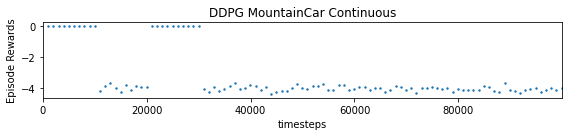

In [0]:

results_plotter.plot_results([log_dir], time_steps, results_plotter.X_TIMESTEPS, "DDPG MountainCar Continuous")
plt.show()

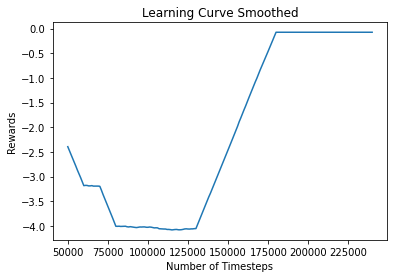

In [0]:
plot_results(log_dir)

### **PPO(Proximal Policy Optimisation)**
PPO is a scalable(to large models and environments), data efficient and robust(does good on many problems without much hyperparameter tuning) method.

With DDPGs the step size hyperparameter has to be tuned correctly for it to achieve good performance and if neglected that could lead to heavy Temporal Difference errors due to vanishing gradients or exploding gradients dependant on magnitude of step size.


So far we know  gradient estimator, 

>$∇_θ J(θ) = ĝ = Ê_t[∇_θ log π_θ(a_t|s_t)Â_t]$

Where all terms follow our definitions so far 
we arrive at $ĝ$ by differentiating:

>$L^{PG}= Ê_t[ log π_θ(a_t|s_t)Â_t]$

This optimisation of loss function defined while arriving at intuition of policy gradients essentially follows uniform trajectory that leads to large policy updates which we solve introducing TRPO on which PPO is based .

#### **Overview of TRPO(Trust Region Policy optimisation)**
When we add constraint to our policy optimization problem we ensure that the updated policy lies in trust region.
For an entire problem, uniform learning rates are wrong idea.
We hence create regions where local approximations hold true and call it trust region. Within a trust region we find local maxima of the policy and iteratively arrive at global maximum of the policy.


>$ {maximize \above 0pt \ θ}   Ê_t [\frac{π_θ(a_t| s_t)}{π_{θ_{old}}(a_t| s_t)}Â_t$

subject to  
>$ Ê_t [KL[π_{θ_{old}}(· | s_t), π_θ(· | s_t)]] ≤ δ{.} $

where ${θ_{old}}$
 is policy parameters before update 

summarizing with pseudocode:
>![alt text](https://miro.medium.com/max/1400/1*BzloIcgP8bTRMslarSQbHw@2x.jpeg)

which leads to solving for :

>$ {maximize \above 0pt \ θ}  Ê_t [\frac{π_θ(a_t| s_t)}{π_{θ_{old}}(a_t| s_t)}Â_t - \beta{KL[π_{θ_{old}}(· | s_t), π_θ(· | s_t)]}$

We do this by solving using conjugate gradient algorithm(we repeatedly make approximations to sub problems to solve a problem) following linear approximation of the below objective and quadratic approximation of constraint described below by TRPO:


>![alt text](https://miro.medium.com/max/1400/1*JspdI6fGh-Cv8OyfqmbwQg@2x.jpeg)

Further, The Fisher Information matrix (F) gives information about how sensitive the probability distribution to different direction in parameter space.

Computing hashing matrix is very expensive in complexity.

We hence solve the problem approximately using conjugate gradient to solve $F.x = g$,  without creating  Fisher matrix $F$.

TRPO hence uses a hard constraint  rather than penalty beacuse it is very difficult to find a single $\beta$ for different problems or complex single problem.


#### **Disadvantages/Limitations of TRPO:**
* Trust Region Polcy optimisation is not good with noises, dropouts or parameter sharing between policy and value functions
* Does poorly on deep CNN, RNN based tasks
* Conjugate gradients very inefficient to implement and solve


#### **Modifications to TRPO to get PPO**
We perform additional modifications to TRPO  such as clipped probability ratios, which forms a pessimistic estimate (i.e., lower bound) of the performance of the policy and  optimizing policies, where we alternate between sampling data from the policy and performing several epochs of optimization on the sampled data to arrive at PPO.

 * **Clipped Surrogate Objective:**

  In PPO we update the policy by minimising the cost function but we ensure that the drift from original policy is small to avoid heavy policy updates.

 Let probability ratio 
 >$ r_t(θ) = [\frac{π_θ(a_t| s_t)}{π_{θ_{old}}(a_t| s_t)}]$ 
 
 such that
  $ r(θ_{old})=1 $

  Since we know TRPO maximises a "surrogate objective"
>$L^{CPI}= Ê_t [\frac{π_θ(a_t| s_t)}{π_{θ_{old}}(a_t| s_t)}Â_t] = Ê_t [r_t(θ)Â_t]$

  where CPI is conservative policy iteration method (see TRPO paper)
As without constraint $L^{CPI}$ performs large policy updates.
in PPO it is suggesested to different constraint:
>$L^{CLIP}(θ)= Ê_t [min (r_t(θ)Â_t, clip(r_t(θ), 1-\epsilon, 1+\epsilon)Â_t)]$

  In addition to minimising TRPO loss, term 1 we modify surrogate objective by clipping the probability ratio. This effectively penalises large policy updates.

  It can be demonstrated with the following graph:
>![alt text](https://miro.medium.com/max/1400/1*a4M7thPEELKKeu4jjpGpiQ@2x.jpeg)


* **Adaptive KL Penalty Coefficient**
Another approach within PPO is using a penalty on KL divergergence that avoids heavy policy updates as well. We control the divergence to $d_{targ}$ value at each policy update
This looks like 
>$L^{KLPEN}(θ)= Ê_t [(r_t(θ)Â_t- \beta KL[π_{θ_{old}}(· | s_t), π_θ(· | s_t)]]$

  We compute divergence value as 
>$d=Ê_t[KL[π_{θ_{old}}(· | s_t), π_θ(· | s_t)]]$

  -If  $d< d_{targ}/1.5, \beta \longleftarrow \beta/2 $ 

  -If  $d> d_{targ} * 1.5, \beta \longleftarrow \beta * 2 $ 

  This is neither sensitive to heuristic values of 1.5 and 2 nor $\beta$

Summarizing this ,  In proximal policy optimization (PPO) algorithm we  use fixed-length trajectory segments as shown below. Each iteration, each of N (parallel) actors collect T timesteps of data. Then  the surrogate loss on these NT timesteps of data is constructed , and we optimize it with minibatch SGD
(or usually for better performance, Adam ), for K epochs as shown in pseudocode below .

#### **Pseudocode of PPO** 

>![alt text](https://i.stack.imgur.com/bVkQH.png)









In [0]:
from stable_baselines import PPO2

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy

env = gym.make('MountainCarContinuous-v0')
env = Monitor(env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])

modelppo = PPO2(MlpPolicy, env, verbose=1)
modelppo.learn(total_timesteps=100000)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Streaming output truncated to the last 5000 lines.
| time_elapsed       | 41.1          |
| total_timesteps    | 57344         |
| value_loss         | 8.9124886e-05 |
--------------------------------------
-------------------------------------
| approxkl           | 0.0013350357 |
| clipfrac           | 0.001953125  |
| ep_len_mean        | 999          |
| ep_reward_mean     | -24.5        |
| explained_variance | -0.0612      |
| fps                | 1441         |
| n_updates          | 449          |
| policy_entropy     | -0.057704695 |
| policy_loss        | -0.00828281  |
| serial_timesteps   | 57472        |
| time_elapsed       | 41.2         |
| total_timesteps    | 57472        |
| value_loss         | 0.0001712795 |
-------------------------------------
--------------------------------------
| approxkl           | 8.873448e-05  |
| clipfrac           | 0.0           |
| ep_len_mean        | 999           |
| ep_reward_mean     | -24.5         |
| explained_variance | -0.00

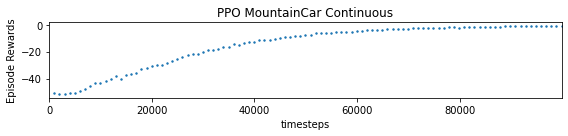

In [0]:

results_plotter.plot_results([log_dir], time_steps, results_plotter.X_TIMESTEPS, "PPO MountainCar Continuous")
plt.show()

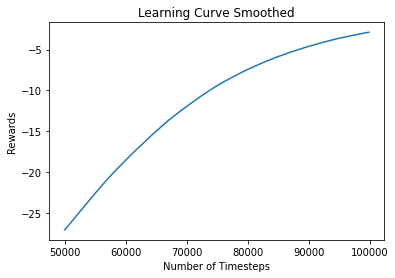

In [0]:
plot_results(log_dir)


### **SAC**
SAC was developed by UCBerkeley and Google to solve and achieve benchmark results in manipulation and locomotion tasks in real-world robots. It is a model free algorithm.

It has the following Advantages:
* Sample Efficiency: 
The learning is very fast in this algorithm and prototyping desired actions for achieving tasks is faster.
* Not sensitive to Hyperparameters 
It uses Maximum entropy RL to minimise dependence on hyperparameters. This aids adaptation on real world tasks without much tuning
* Off - Policy Learning
 We can reuse data for learning seperate task.This aids us to use past experiences and previously developed policy for other tasks

It uses entropy in policy to calculate reward to encourage exploration. 
It has an actor-critic framework that aids to update policy and value function separately as discussed in previos sections.
Using abouve notations this framework utilises equation:
$J(θ)=∑_{t=1}^TE_{(s_t,a_t)∼ρπθ}[r(s_t,a_t)+αH(π_θ(.|s_t))]$

where $H(.)$ is entropy metric and  α is the measure of importance to entropy metric popularly known as 'temparature' parameter
Entropy maximisation leads to more exploration and assigning equal probabilities to actions that are equally good

SAC has 3 functions to learn:

1) policy  with parameters θ, $\pi_θ$

2) soft Q-value function parameterized by w, $Q_w$.

3)Soft state value function parameterized by ψ, $V_ψ$; theoretically we can infer V by knowing Q and π, but in practice, it helps stabilize the training. 

Soft Q-value and soft state value are defined as:

where $Q(s_t,a_t)=r(s_t,a_t)+γE_{s_{t+1}∼ρπ(s)}[V(s_{t+1})]$ -- From Bellman's Equation
where
$V(s_t)=E_{at∼π}[Q(s_t,a_t)−αlogπ(a_t|s_t)]$; --Soft state value function

Thus, $Q(s_t,a_t)=r(s_t,a_t)+γE_{(s_{t+1},a_{t+1})∼ρπ}[Q(s_{t+1},a_{t+1})−αlogπ(a_{t+1}|s_{t+1})]$

Here ρπ(s) and ρπ(s,a) denote the state and the state-action marginals of the state distribution induced by the policy π(a|s)

The soft state value function is trained to minimize the mean squared error:

$J_V(ψ)=E_{s_t∼D}[\frac{1}{2}(V_ψ(s_t)−E[Q_w(s_t,a_t)−logπ_θ(a_t|s_t)])^2]$

with gradient: 

$∇_ψJ_V(ψ)=∇_ψV_ψ(s_t)(V_ψ(s_t)−Q_w(s_t,a_t)+logπ_θ(a_t|s_t))$


where D is the replay buffer.

The soft Q function is trained to minimize the soft Bellman residual:

$J_Q(w)=E_{(s_t,a_t)∼D}[\frac{1}{2}(Q_w(s_t,a_t)−(r(s_t,a_t)+γE_{s_{t+1}∼ρπ(s)}[V_ψ^¯(s_{t+1})]))^2]$

with gradient:

 $∇_wJ_Q(w)=∇_wQ_w(s_t,a_t)(Q_w(s_t,a_t)−r(s_t,a_t)−γV_ψ^¯(s_{t+1}))$

where ψ¯ is the target value function which is the exponential moving average (or only gets updated periodically in a “hard” way), just like how the parameter of the target Q network is treated in DQN to stabilize the training.

SAC updates the policy to minimize the KL-divergence:

$ π_{new}= argmin_{π′∈Π}D_{KL}(π′(.|s_t)∥\frac{exp(Q^{π_old}(s_t,.))}{Z^{π_old}(s_t)})$

objective for update: 
$J_π(θ)=∇_θD_{KL}(π_θ(.|s_t)∥exp(Q_w(s_t,.)−logZ_w(s_t)))$

  $= E_{a_t∼π}[−log(\frac{exp(Q_w(s_t,a_t)−logZ_w(s_t))}{π_θ(a_t|s_t)})]$

$  =E_{a_t∼π}[logπ_θ(a_t|s_t)−Q_w(s_t,a_t)+logZ_w(s_t)]
$

where Π is the set of potential policies that we can model our policy as to keep them tractable; for example, Π can be the family of Gaussian mixture distributions, expensive to model but highly expressive and still tractable.$ Z^{π_{old}}(s_t)$ is the partition function to normalize the distribution. It is usually intractable but does not contribute to the gradient. How to minimize $J_π(θ)$ depends our choice of Π.

This update guarantees that $Q^{π_{new}}(s_t,a_t)≥Q^{π_{old}}(s_t,a_t)$

Once we have defined the objective functions and gradients for soft action-state value, soft state value and the policy network, the soft actor-critic algorithm is straightforward:


 **Pseudocode of SAC algorithm:**
 ![alt text](https://lilianweng.github.io/lil-log/assets/images/SAC_algo.png)




In [0]:
from stable_baselines import SAC

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.sac.policies import  MlpPolicy 

env = gym.make('MountainCarContinuous-v0')
env = Monitor(env, log_dir, allow_early_resets=True)
env = DummyVecEnv([lambda: env])

modelsac = SAC(MlpPolicy, env, verbose=1)
modelsac.learn(total_timesteps=100000)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


-------------------------------------------
| current_lr              | 0.0003        |
| ent_coef                | 0.41950208    |
| ent_coef_loss           | -1.4529761    |
| entropy                 | 1.2387763     |
| ep_rewmean              | -33.4         |
| episodes                | 4             |
| eplenmean               | 999           |
| fps                     | 323           |
| mean 100 episode reward | -33.4         |
| n_updates               | 2897          |
| policy_loss             | -5.129809     |
| qf1_loss                | 0.00039952318 |
| qf2_loss                | 0.0004130964  |
| time_elapsed            | 9             |
| total timesteps         | 2997          |
| value_loss              | 0.00086907635 |
-------------------------------------------
-------------------------------------------
| current_lr              | 0.0003        |
| ent_coef                | 0.12695381    |
| ent_coef_loss           | -3.40457      |
| entropy                 | 1.11

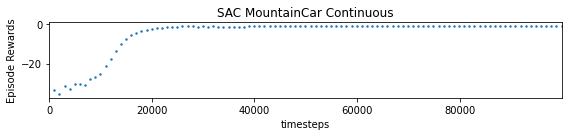

In [0]:
results_plotter.plot_results([log_dir], time_steps, results_plotter.X_TIMESTEPS, "SAC MountainCar Continuous")
plt.show()

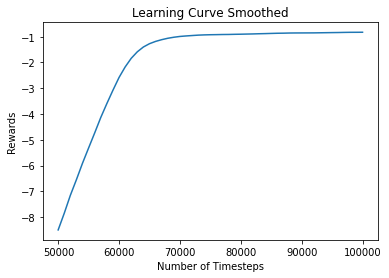

In [0]:
plot_results(log_dir)


### **INFERENCE:**

We see that the DDPG does reach goal state around 180000 timestep versus PPO that reaches goal state at 62000 timestep versus SAC that reaches goal state in 70000 time step. The Learning rate in PPO is very gradual suggesting its carefullness. SAC however has quick learning time  and hence can be used for more real world applications as explained from our discussion above analysing these algorithms.


### **QUIZ:** 

State true/False:

1. SAC is a on-policy based RL algorithm

    A.  False. It is Off Policy algorithm that uses past experience knowledge from previous experiences of another policy
    

2.  PPO is sensitive to hyperparameters such as heuristic values used in surrogate loss function?

    A. False 
    

3.  Q-learning can learn the optimal Q-function Q∗ without ever executing the optimal policy.

    A. True. It arrives at optimal policy by updating Q table using TD like algorithms


4. Off-policy algorithms can learn from data without interacting with the environment

    A. True. They can update target policy by using experience of any other behaviour policy
    

5. DDPG is a purely off policy algorithm
  
    A. False. DDPG uses behavioral policy that is acquired from adding noise to actions achieved from target policy hence behavioral policy is not decorrelated from target policy.
    
  
6. There are  2 states and 1 action in  MountainCarContinuous-v0 agent .

    A.  True but these have Continuous values in ranges specified above.


7. SAC is a Model Based Reinforcement Learning Algorithm

    A. False
    
  
8. TRPO with penalties on large policy updates and surrogate loss gradual optimisation are primary ideas of PPO

    A. True




### REFERENCES:
1)https://towardsdatascience.com/an-intuitive-explanation-of-policy-gradient-part-1-reinforce-aa4392cbfd3c

2) https://towardsdatascience.com/reinforcement-learning-with-hindsight-experience-replay-1fee5704f2f8

3)https://towardsdatascience.com/policy-gradients-in-a-nutshell-8b72f9743c5d

4) Sutton, R. S. and Barto, A. G. (1998). Introduction to Reinforcement Learning. MIT Press, Cambridge, MA, USA, 1st edition.

5)Silver, D., Lever, G., Heess, N., Degris, T., Wierstra, D., and Riedmiller, M. (2014). Deterministic policy gradient algorithms. In Xing, E. P. and Jebara, T., editors, Proceedings of the 31st International Conference on Machine Learning, volume 32 of Proceedings of Machine Learning Research, pages 387–395, Bejing, China. PMLR.
6) Timothy P. Lillicrap, Jonathan J. Hunt, Alexander Pritzel, Nicolas Heess, Tom Erez, Yuval Tassa, David Silver, and Daan Wierstra, Continuous control with deep reinforcement learning, CoRR abs/1509.02971 (2015).

7) [Edouard Leurent’s answer to Quora post “Why do we use the Ornstein Uhlenbeck Process in the exploration of DDPG?” ](https://qr.ae/TW8NAa)

8)https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b

9)Soft Actor-Critic: Off-Policy Maximum Entropy Deep Reinforcement Learning with a Stochastic Actor. Haarnoja et al. (2018)
10)Soft Actor-Critic Algorithms and Applications. Haarnoja et al. (2019)

11)https://www.youtube.com/watch?v=xvRrgxcpaHY&t=363s

12) https://medium.com/@sanketgujar95/trust-region-policy-optimization-trpo-and-proximal-policy-optimization-ppo-e6e7075f39ed

13) Schulman, J.; Wolski, F.; Dhariwal, P.; Radford, A.; and Klimov,
O. 2017. Proximal policy optimization algorithms. arXiv preprint
arXiv:1707.06347.

14)https://mc.ai/rl-the-math-behind-trpo-ppo/

15) https://stable-baselines.readthedocs.io/en/master/

16) https://github.com/openai/gym/wiki/MountainCarContinuous-v0



### **LICENSE**

#### **CREATIVE LICENSE**

License terms can be found [here](https://creativecommons.org/licenses/by/4.0/legalcode).

#### **SOFTWARE LICENSE**

MIT License

Copyright (c) 2020 Suprita Ganesh

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
